In [4]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path 
sys.path.append('/home/aesgeorges/LaGonaveFM/')
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import geopandas as gpd

import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr

import fiona
from shapely.geometry import shape

#from cmcrameri import cm as cmc

#  Analysis of Mangrove Retreat + Sea Level Rise ADCIRC Simulations

Featuring modded Hurricane Matthew Track v1

In [8]:
scenario_r0 = 'Gonave_SLR_retreats/r0' # No Retreat (Close to 2010 cover)
scenario_r1 = 'Gonave_SLR_retreats/r1' # Light Retreat (Close to 2020 cover)
scenario_r2 = 'Gonave_SLR_retreats/r2'
scenario_r3 = 'Gonave_SLR_retreats/r3'

root = f'../sims/'

cities_extents = '../datasets/other/cities.shp'

In [5]:
# Read the shapefile using fiona
with fiona.open(cities_extents, 'r') as src:
    cities = pd.DataFrame([feature['properties'] for feature in src])
    cities['geometry'] = [shape(feature['geometry']) for feature in src]

cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry')
cities_gdf

,id,geometry
0,0,"POLYGON ((-72.65229 19.30147, -72.65162 19.301..."
1,1,"POLYGON ((-72.60486 19.31420, -72.60363 19.314..."
2,3,"POLYGON ((-72.69655 19.45433, -72.69628 19.455..."


In [45]:
def scenario_data(scenario, year):
    r0_path = f'{root}{scenario_r0}/{scenario}_{year}/hotstart/maxele.63.nc'
    r0_data = netcdf.Dataset(r0_path, 'r') # Baseline Sim

    r1_path = f'{root}{scenario_r1}/{scenario}_{year}/hotstart/maxele.63.nc'
    r1_data = netcdf.Dataset(r1_path, 'r') # Mangrove S0 Medium Retreat Sim

    r2_path = f'{root}{scenario_r2}/{scenario}_{year}/hotstart/maxele.63.nc'
    r2_data = netcdf.Dataset(r2_path, 'r') # Mangrove S0 Medium Retreat Sim

    r3_path = f'{root}{scenario_r3}/{scenario}_{year}/hotstart/maxele.63.nc'
    r3_data= netcdf.Dataset(r3_path, 'r') # Mangrove S0 Heavy Retreat Sim

    return r0_data, r1_data, r2_data, r3_data

In [29]:
def plot_flood_extent(run, ax, color):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

In [ ]:
def plot_flood_extent_comparisons(r0_data, r1_data, r2_data, r3_data, title_scene):
    fig, ax = plt.subplots(figsize = (10,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

    custom_gradient = ["#0004FF", "#30c67c", "#FF930F", "#FF0000"]

    plot_flood_extent(r0_data, ax, custom_gradient[0])
    plot_flood_extent(r1_data, ax, custom_gradient[1])
    plot_flood_extent(r2_data, ax, custom_gradient[2])
    plot_flood_extent(r3_data, ax, custom_gradient[3])

    ax.legend(handles=[mpl.lines.Line2D([], [], color=custom_gradient[0], label=f'R0 S0 - Baseline'),
                    mpl.lines.Line2D([], [], color=custom_gradient[1], label=f'R1 S0 - Light Retreat'),
                    mpl.lines.Line2D([], [], color=custom_gradient[2], label=f'R2 S0 - Medium Retreat'),     
                    mpl.lines.Line2D([], [], color=custom_gradient[3], label=f'R3 S0 - Heavy Retreat')], loc='upper left')

    cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
            ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    ax.add_feature(cf.LAKES)
    ax.add_feature(coast)

    ax.set_title(f'Inundation Extents for Different Mangrove Retreats - {title_scene}', fontsize=12)

In [19]:
r0_s0_path = f'{root}{scenario_r0}/S0/hotstart/maxele.63.nc'
r0_s0_data = netcdf.Dataset(r0_s0_path, 'r') # Baseline Sim

r1_s0_path = f'{root}{scenario_r1}/S0/hotstart/maxele.63.nc'
r1_s0_data = netcdf.Dataset(r1_s0_path, 'r') # Mangrove S0 Medium Retreat Sim

r2_s0_path = f'{root}{scenario_r2}/S0/hotstart/maxele.63.nc'
r2_s0_data = netcdf.Dataset(r2_s0_path, 'r') # Mangrove S0 Medium Retreat Sim

r3_s0_path = f'{root}{scenario_r3}/S0/hotstart/maxele.63.nc'
r3_s0_data = netcdf.Dataset(r3_s0_path, 'r') # Mangrove S0 Heavy Retreat Sim

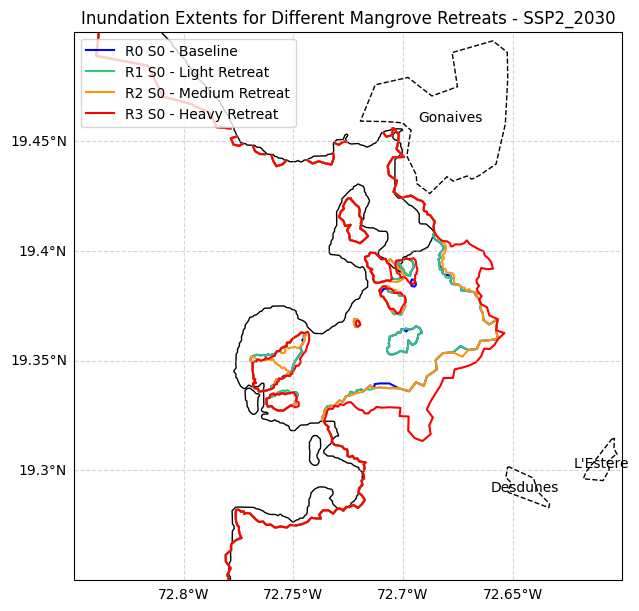

In [46]:
plot_flood_extent_comparisons(r0_s0_data, r1_s0_data, r2_s0_data, r3_s0_data)

In [50]:
scenario = 'SSP2'
year = '2100'

r0_data, r1_data, r2_data, r3_data = scenario_data(scenario, year)

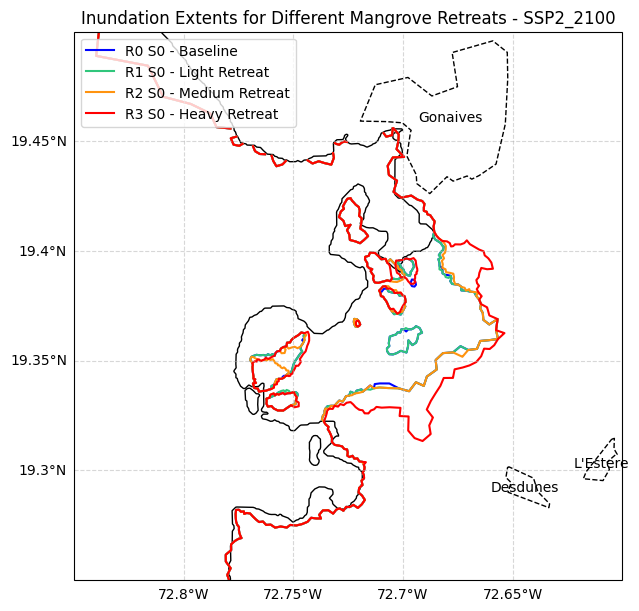

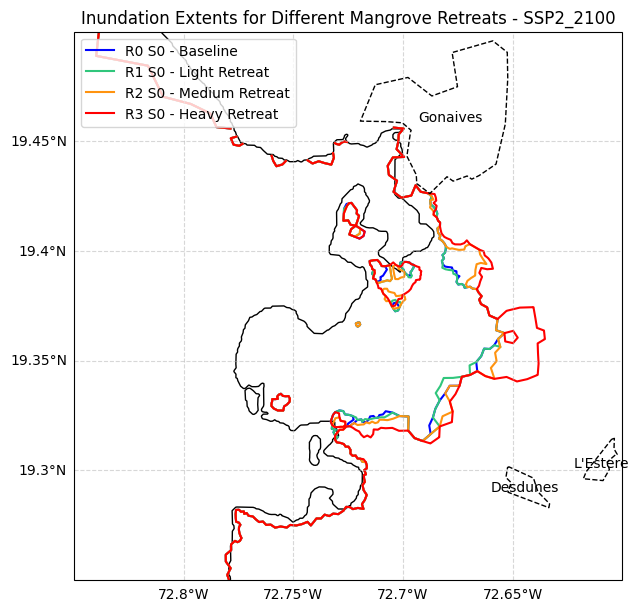

In [ ]:
plot_flood_extent_comparisons(r0_s0_data, r1_s0_data, r2_s0_data, r3_s0_data, 
                              title_scene = 'No SLR')
plot_flood_extent_comparisons(r0_data, r1_data, r2_data, r3_data,
                              title_scene = f'{scenario}_{year}')